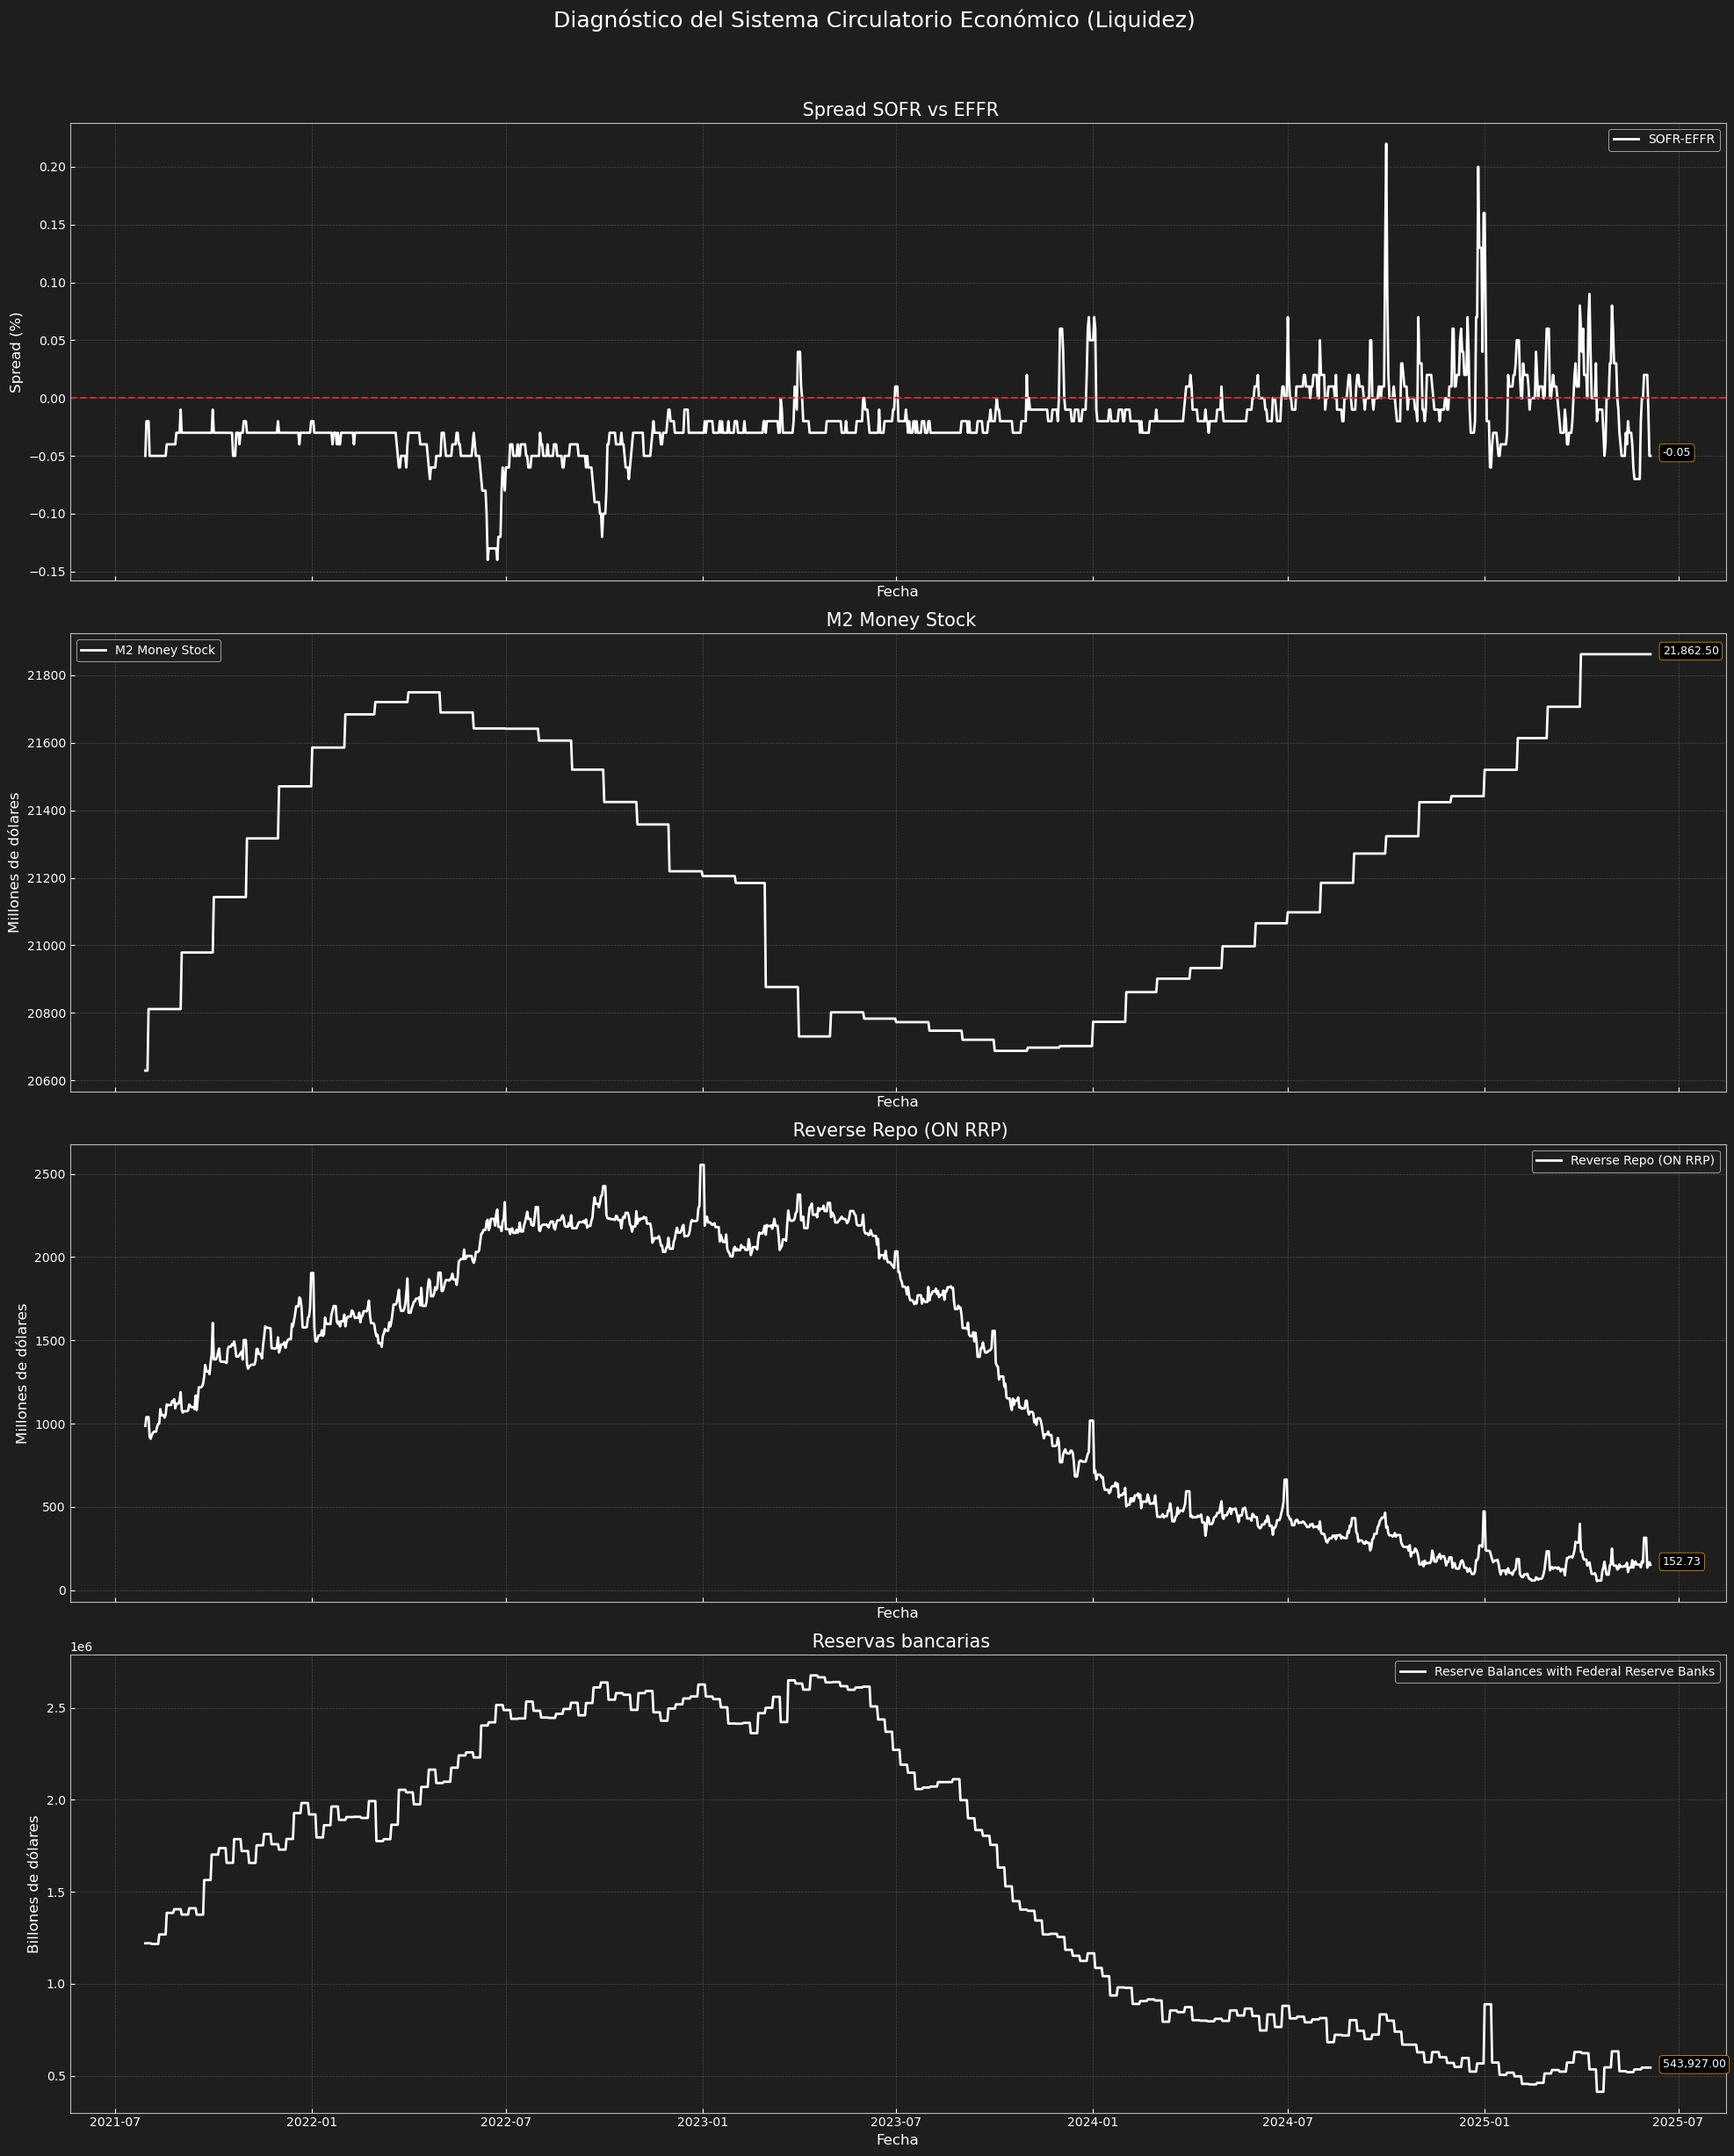

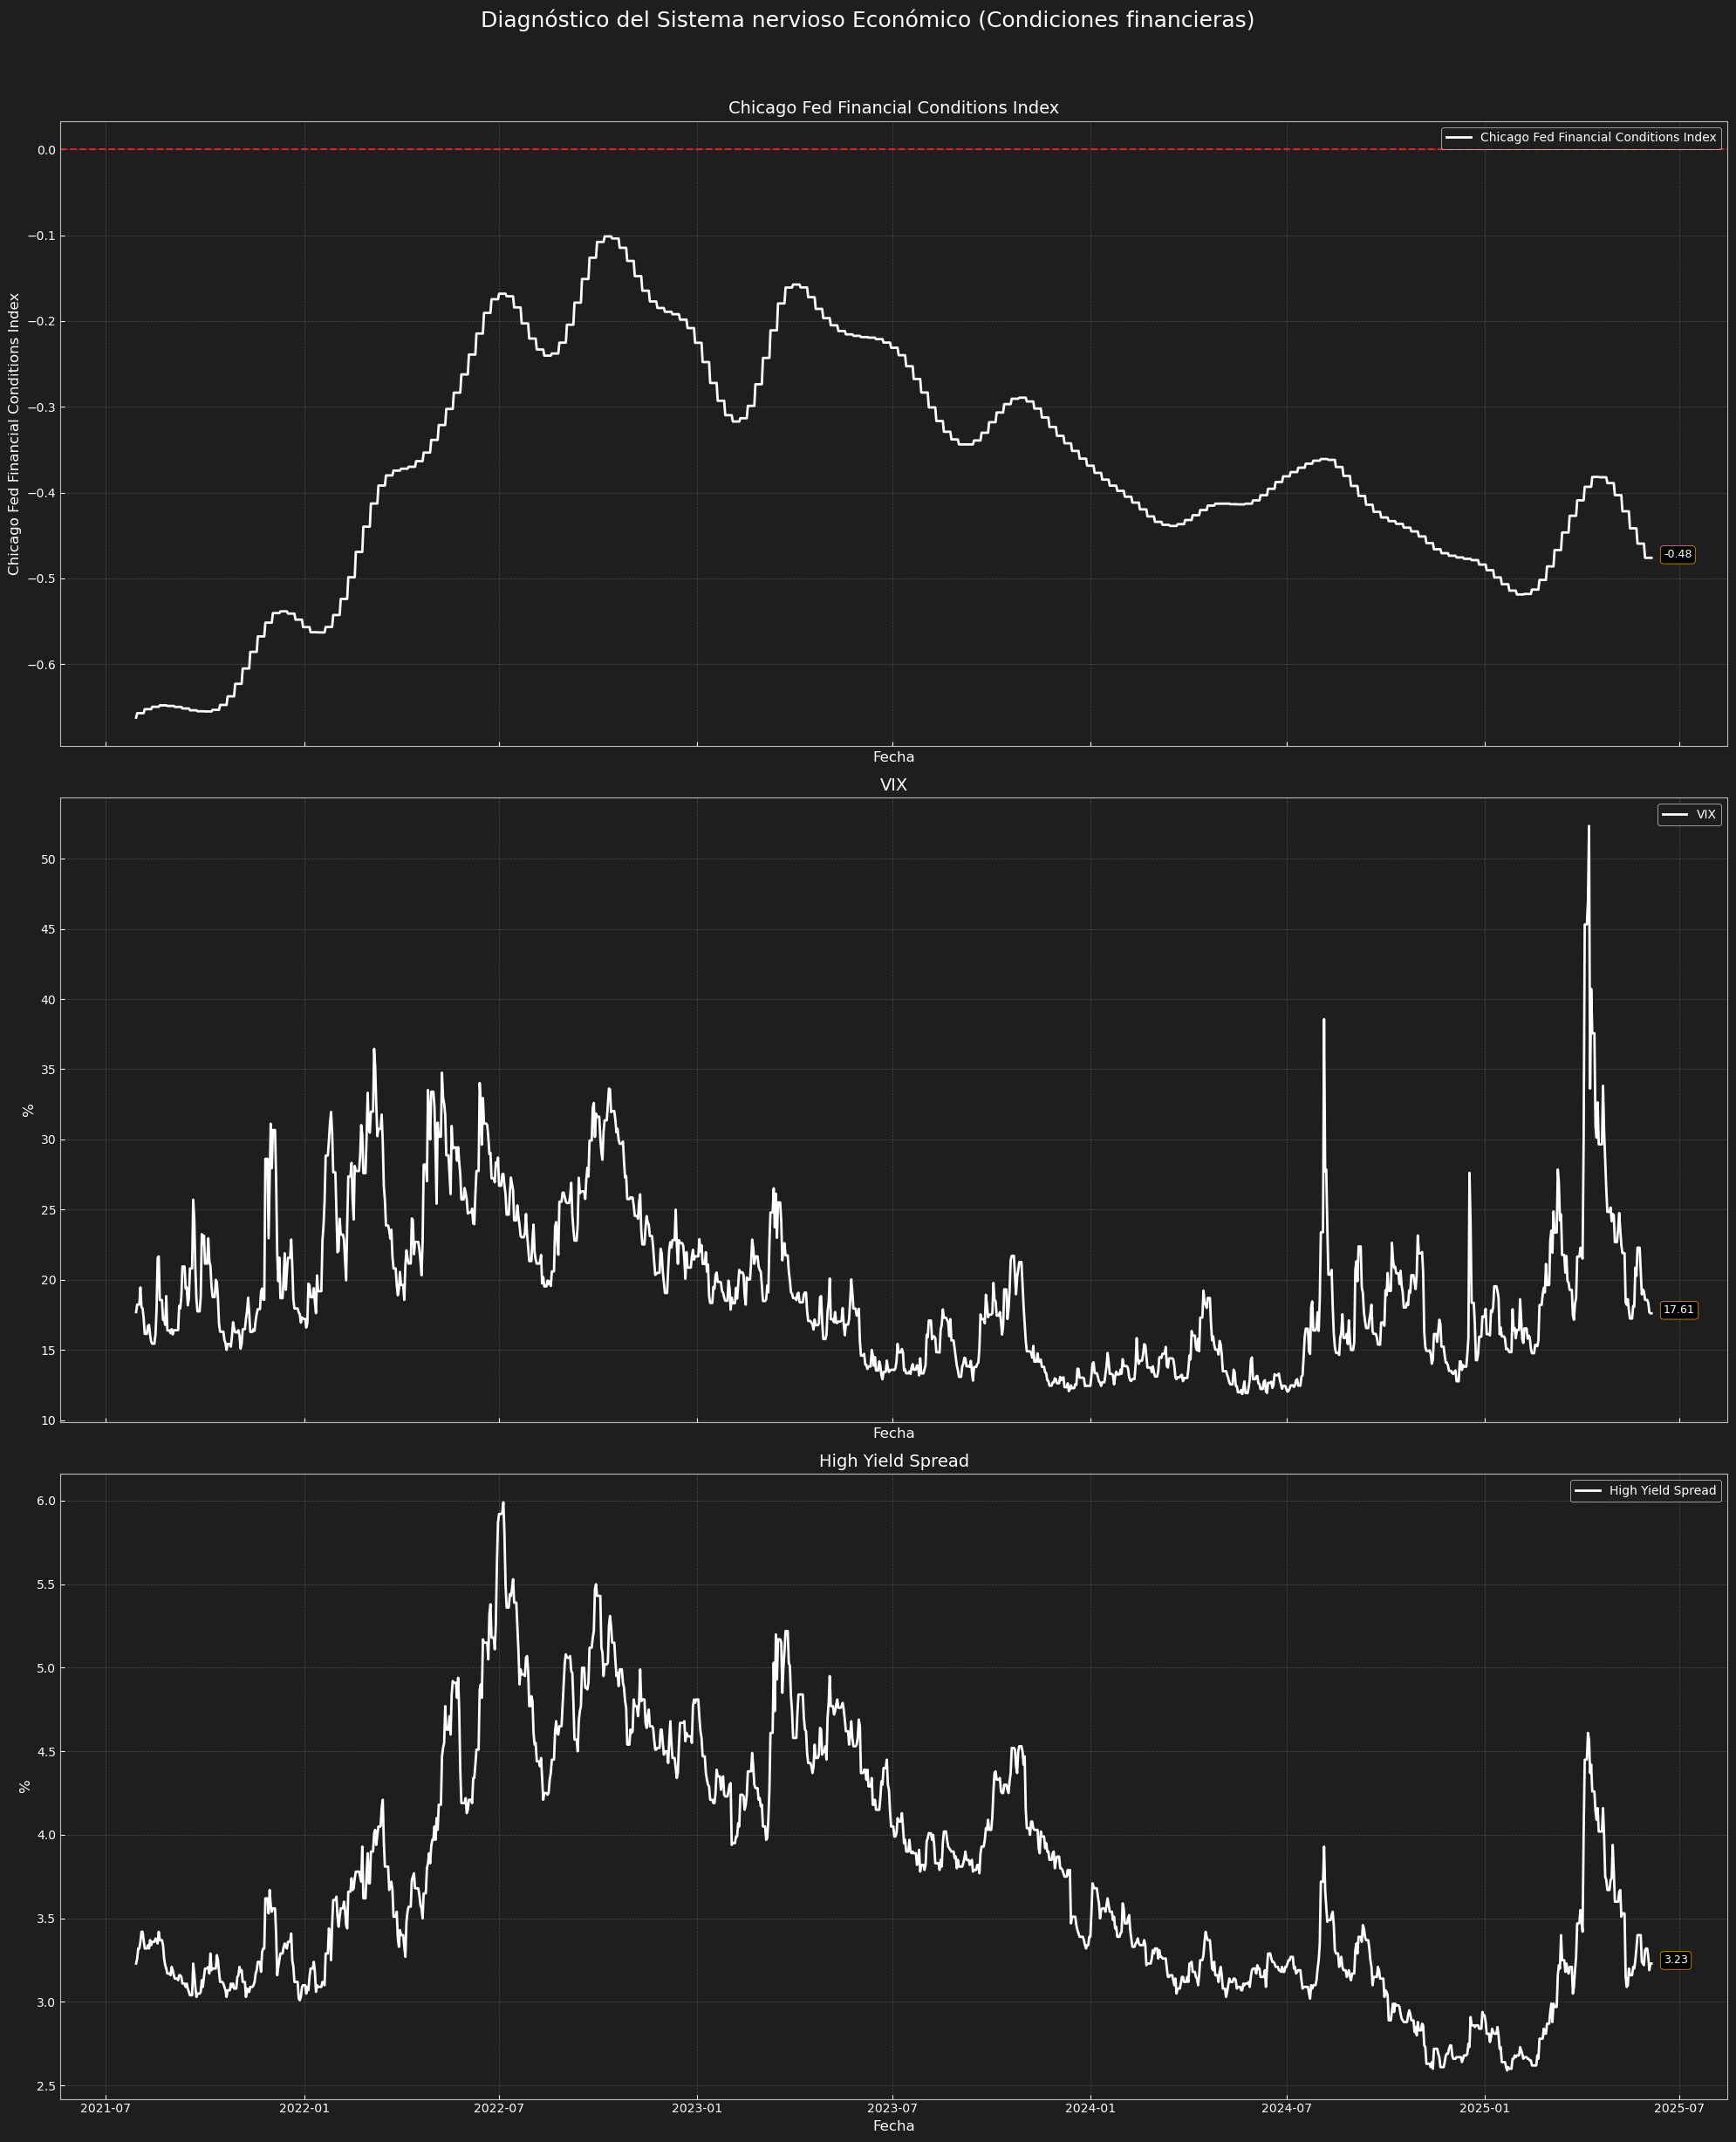

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import time
import datetime as dt

from tiingo import TiingoClient
import pandas_datareader.data as web
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fredapi import Fred
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from datetime import datetime


# PROYECTO ANATOMIA ECONOMICA 
# Obejtivo : analizar y preparar medidas de inversion en el ambiente macroeconomico
"""
üßç Diagn√≥stico Fisiol√≥gico ‚Äì √ìrganos y Sistemas Econ√≥micos

‚Ä¢	ü´Ä Circulatorio (Liquidez): RRP, SOFR‚ÄìEFFR, M2, Reservas.
‚Ä¢	üß† Nervioso (Condiciones financieras): NFCI, VIX, HY Spread.
‚Ä¢	ü´Å Pulmones (Curva de rendimiento): 2Y‚Äì10Y, BAA, pr√©stamos.
‚Ä¢	üß¨ Metabolismo (Empleo y actividad): ICSA, horas trabajadas, PCE.
‚Ä¢	üß™ Inmunol√≥gico (Shadow banking): spreads, RRP, colateral.
‚Ä¢	ü¶æ Muscular (Producci√≥n industrial): PMI, producci√≥n, capacidad.
‚Ä¢	ü¶† Linf√°tico (Cadenas log√≠sticas): Freight, GSCPI.
‚Ä¢	üßΩ Ri√±ones (Filtrado Fed): QE, balance, BTFP.
‚Ä¢	üßπ H√≠gado (Digesti√≥n bancaria): cr√©dito bancario, pr√©stamos.
‚Ä¢	ü´Ñ √ötero (Innovaci√≥n): IPOs, productividad, gasto en I+D.
‚Ä¢	ü¶¥ √ìseo (Instituciones): gobernabilidad, CPI institucional.
‚Ä¢	ü´¶ Comunicaci√≥n (Mercados): bid-ask, volumen, distorsi√≥n.
‚Ä¢	üßò Aut√≥nomo (Pol√≠tica fiscal/monetaria): d√©ficit, tasas, impulso.
‚Ä¢	üçΩÔ∏è Digestivo (Consumo): Retail sales, confianza consumidor.
‚Ä¢	üå°Ô∏è Temperatura (Inflaci√≥n): CPI, core CPI, sticky CPI.
‚Ä¢	üåê Piel (Externo): balanza comercial, flujos capitales.

üß† Capa de Inteligencia Estrat√©gica
‚Ä¢	Genera sugerencias t√°cticas basadas en alertas activas.
‚Ä¢	Ejemplo: stress de liquidez + curva invertida ‚Üí rotar a cash y T-Bills.
‚Ä¢	Matriz de decisiones para acciones sugeridas.

üìà Capa de Momentum y Aceleraci√≥n
‚Ä¢	Detecta el ritmo del deterioro o mejora.
‚Ä¢	Incluye tasas de cambio, z-score de momentum.
‚Ä¢	Se√±ala si el problema est√° estabilizado o agrav√°ndose.

üìä Capa Comparativa Temporal
‚Ä¢	C√≥mo estamos hoy vs hace 1, 3, 6, 12 meses.
‚Ä¢	Evoluci√≥n de sub√≠ndices compuestos y alertas activas.
‚Ä¢	Visualizaci√≥n tipo radar o heatmap.

üìö Capa de Storytelling Econ√≥mico
‚Ä¢	Agrega interpretaci√≥n narrativa: ¬øqu√© historia est√°n contando los datos?
‚Ä¢	Ej: ‚ÄúEsto se parece al ciclo 2011-2012‚Äù, o ‚ÄúDesaceleraci√≥n con inflaci√≥n‚Äù
‚Ä¢	Agrega etiquetas a eventos clave sobre el timeline.

üõ°Ô∏è Capa de Defensa y Cobertura
‚Ä¢	Eval√∫a exposici√≥n actual y estrategias de protecci√≥n.
‚Ä¢	Ejemplo: VIX bajo + FOMO ‚Üí agregar puts o rotar a oro.
‚Ä¢	Sugiere portafolio defensivo basado en condiciones.

üéØ Capa de Acci√≥n Directa
‚Ä¢	Traduce se√±ales en decisiones de rotaci√≥n de activos.
‚Ä¢	Propuesta de asignaci√≥n por clase: equity, bonos, cash, commodities.
‚Ä¢	Filtro de sectores sugeridos por fase del ciclo.

üß† Capa Predictiva con Machine Learning
‚Ä¢	Entrenar modelos con tus propios √≠ndices compuestos.
‚Ä¢	Detectar patrones de crisis antes de que se activen alertas duras.
‚Ä¢	Clustering para encontrar reg√≠menes ocultos de mercado.


"""
fred = Fred(api_key="02ea49012ba021ea89f1110c48de7380")

start = '2021-01-01'
end = dt.datetime.today()


series = {
        # üü¶ Tasas clave
    "SOFR": "SOFR (Secured Overnight Financing Rate)",
    "FEDFUNDS": "Effective Federal Funds Rate",
    "IORB": "Interest Rate on Reserve Balances",
    "EFFR": "Effective Federal Funds Rate (Alt)",

    # üü© Curva de rendimiento y spreads
    "DGS2": "2Y Treasury Yield",
    "DGS10": "10Y Treasury Yield",
    "DTB3": "3M T-Bill Yield",
    "BAA10Y": "BAA Spread over 10Y Treasury",
    "BAMLC0A4CBBBEY": "Yield on BBB Corporate Bonds",

    # üüß Liquidez bancaria y de mercado
    "RRPONTSYD": "Reverse Repo (ON RRP)",
    "WALCL": "Fed Balance Sheet Total Assets",
    "WLRRAL": "Reserve Balances with Federal Reserve Banks",
    "M2SL": "M2 Money Stock",
    "M2V": "Velocity of M2 Money Stock",
    "TOTBKCR": "Total Bank Credit",
    "COMPOUT": "Commercial Paper Outstanding",

    # üü• Riesgo crediticio
    "BAMLH0A0HYM2": "High Yield Spread",

    # üü® Condiciones financieras
    "NFCI": "Chicago Fed Financial Conditions Index",

    # üü™ Expectativas macroecon√≥micas
    "T5YIE": "5Y Breakeven Inflation Rate",
    "USRECD": "Recession Indicator (NBER Binary)",
    "ICSA": "Initial Jobless Claims",
    "TEDRATE": "TED Spread (LIBOR - T-Bill 3M)", # 
     # üü´ Hogares y empleo
    "TNWBSHNO": "Household and Nonprofit Net Worth",
    "AWHAETP": "Avg Weekly Hours of All Employees (Total Private)",
    
    # üü¶ Balance del Sistema de la Fed
    

    # (opcionalmente m√°s)
    "UNRATE": "Unemployment Rate",
    "CPIAUCSL": "CPI - All Urban Consumers",
    "PCE": "Personal Consumption Expenditures",
    "HOUST": "Housing Starts",

    'VIXCLS': "VIX"
    
}

data = {}

for series_id, name in series.items():
    data[name] = fred.get_series(series_id, start, end)

df = pd.DataFrame(data)
df.index = pd.to_datetime(df.index)

df_full = df.resample('D').last().ffill().dropna()


df_full['SOFR-EFFR'] = (
    df_full["SOFR (Secured Overnight Financing Rate)"] - 
    df_full["Effective Federal Funds Rate (Alt)"]
)

#Corazon (Liquidez
df_corazon = df_full[[ 
    "SOFR-EFFR",
    "M2 Money Stock",
    "Reserve Balances with Federal Reserve Banks",
    "Reverse Repo (ON RRP)"
]]

#Graficos corazon

plt.style.use("bmh")
fig, ax = plt.subplots(4, 1, figsize=(20, 25), sharex=True)

# Fondo general oscuro
fig.patch.set_facecolor("#1E1E1E")

# Lista de colores y t√≠tulos para personalizar
colores = ["#FFFFFF"] * 4
titulos = [
    "Spread SOFR vs EFFR",
    "M2 Money Stock",
    "Reverse Repo (ON RRP)",
    "Reservas bancarias"
]
series = [
    "SOFR-EFFR",
    "M2 Money Stock",
    "Reverse Repo (ON RRP)",
    "Reserve Balances with Federal Reserve Banks"
]
ylabels = [
    "Spread (%)",
    "Millones de d√≥lares",
    "Millones de d√≥lares",
    "Billones de d√≥lares"
]

# Iteraci√≥n por subplot
for i in range(4):
    ax[i].plot(df_corazon.index, df_corazon[series[i]], color=colores[i], linewidth=2, label=series[i])
    ax[i].set_facecolor("#1E1E1E")
    if i not in [1,2,3]:
        ax[i].axhline(0, color="#D62728", linestyle="--", linewidth=1.5)
    ax[i].set_title(f" {titulos[i]}", color="white", fontsize=15)
    if df_corazon["SOFR-EFFR"].iloc[-1] > 0:
        ax[1].axvspan(df_corazon.index[-5], df_corazon.index[-1], color='red', alpha=0.2)


    ax[i].set_ylabel(ylabels[i], color="white")
    ax[i].set_xlabel("Fecha", color="white")
    ax[i].tick_params(axis='x', colors='white')
    ax[i].tick_params(axis='y', colors='white')
    ax[i].grid(True, linestyle="--", alpha=0.3)
    ax[i].legend(facecolor="#1E1E1E", edgecolor="white", labelcolor="white")

    # üè∑Ô∏è Anotar el √∫ltimo valor
    ultimo_valor = df_corazon[series[i]].iloc[-1]
    ultima_fecha = df_corazon.index[-1]
    ax[i].annotate(f"{ultimo_valor:,.2f}",
                   xy=(ultima_fecha, ultimo_valor),
                   xytext=(10, 0),
                   textcoords='offset points',
                   color="white",
                   fontsize=9,
                   bbox=dict(boxstyle="round", fc="black", ec="orange"))

# T√≠tulo general
fig.suptitle("Diagn√≥stico del Sistema Circulatorio Econ√≥mico (Liquidez)", color="white", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



#Sistema nerviioso

df_cerebro = df_full[[
    "Chicago Fed Financial Conditions Index",
    "VIX",
    "High Yield Spread"
]]

plt.style.use("bmh")
fig, ax1 = plt.subplots(3,1,figsize=(20,25), sharex=True)

fig.patch.set_facecolor("#1E1E1E")


colores = ["#FFFFFF"] * 4
series = ["Chicago Fed Financial Conditions Index", "VIX", "High Yield Spread"]
titulos = ["Chicago Fed Financial Conditions Index", "VIX", "High Yield Spread"]
ylabels = ["Chicago Fed Financial Conditions Index", "%", "%"]

for i in range(3):
    ax1[i].plot(df_cerebro.index, df_cerebro[series[i]], color=colores[i], linewidth=2, label=series[i])
    ax1[i].set_facecolor("#1E1E1E")
    ax1[i].set_title(titulos[i], color="white", fontsize=14)
    ax1[i].set_ylabel(ylabels[i], color="white")
    ax1[i].set_xlabel("Fecha", color="white")
    ax1[i].tick_params(axis='x', colors='white')
    ax1[i].tick_params(axis='y', colors='white')
    ax1[i].grid(True, linestyle="--", alpha=0.3)
    ax1[i].legend(facecolor="#1E1E1E", edgecolor="white", labelcolor="white")
    if i not in [1,2]:
        ax1[i].axhline(0, color="#D62728", linestyle="--", linewidth=1.5)
    ultimo_valor = df_cerebro[series[i]].iloc[-1]
    ultima_fecha = df_cerebro.index[-1]
    ax1[i].annotate(f"{ultimo_valor:,.2f}",
                   xy=(ultima_fecha, ultimo_valor),
                   xytext=(10, 0),
                   textcoords='offset points',
                   color="white",
                   fontsize=9,
                   bbox=dict(boxstyle="round", fc="black", ec="orange"))
    
fig.suptitle("Diagn√≥stico del Sistema nervioso Econ√≥mico (Condiciones financieras)", color="white", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

    







